In [0]:
# import standard libraries

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn import tree

from imblearn.under_sampling import (CondensedNearestNeighbour,
                                     RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
# from imblearn.over_sampling import (SMOTE,SVMSMOTE,SMOTENC)
# from imblearn.combine import (SMOTEENN,SMOTETomek)

from sklearn.metrics import classification_report, confusion_matrix,f1_score
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')


In [0]:
# Do not change the function
# This function is adapted from the sklearn website
# This function let you draw a confusion matrix for your problem

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [133]:
# load train data
train_data = pd.read_csv('/content/drive/My Drive/SYDE 522 Project/MoreManipulatedData_bucket_last_col.csv',usecols=lambda x: 'PLAYER_URL' not in x)

# different classes
train_data.BUCKET.unique()

array([' 1-200   ', ' 601+    ', ' 201-600 ', '0'], dtype=object)

In [178]:
# convert string values to numerical data
def convert(data):
    number = preprocessing.LabelEncoder()
    data['POS'] = number.fit_transform(data.POS)
    data['LEAGUE'] = number.fit_transform(data.LEAGUE)
    data['FIRST_JUNIOR_YEAR'] = number.fit_transform(data.FIRST_JUNIOR_YEAR)
    data['DOB'] = number.fit_transform(data.DOB)
    data['NATIONALITY'] = number.fit_transform(data.NATIONALITY)
    data['SHOOTS'] = number.fit_transform(data.SHOOTS)
    data=data.fillna(-999)
    return data

# convert string values in data to numerical classes
train_data=convert(train_data)

# Separating the data and the labels
X = np.asarray(train_data[train_data.columns[:-1]])
y = np.asarray(train_data.BUCKET)

# Splitting the data into the train and the test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

print('Training data: \n',X)
print('\n')
print('Training labels: \n',y_train)


Training data: 
 [[103143      3     87 ...    180     84      2]
 [106210      1     73 ...    193     95      0]
 [106207      2     21 ...    183     86      0]
 ...
 [249307      1    130 ...    188     98      3]
 [485033      3     59 ...    175     68      2]
 [410552      2      1 ...    183     82      2]]


Training labels: 
 ['0' '0' '0' ... '0' '0' '0']


              precision    recall  f1-score   support

    1-200          0.43      0.43      0.43       408
    201-600        0.32      0.22      0.26       156
    601+           0.47      0.53      0.49       127
           0       0.96      0.97      0.96      6009

    accuracy                           0.91      6700
   macro avg       0.55      0.53      0.54      6700
weighted avg       0.90      0.91      0.91      6700

Confusion matrix, without normalization
[[ 174   32   21  181]
 [  43   34   36   43]
 [  33   17   67   10]
 [ 154   22   20 5813]]


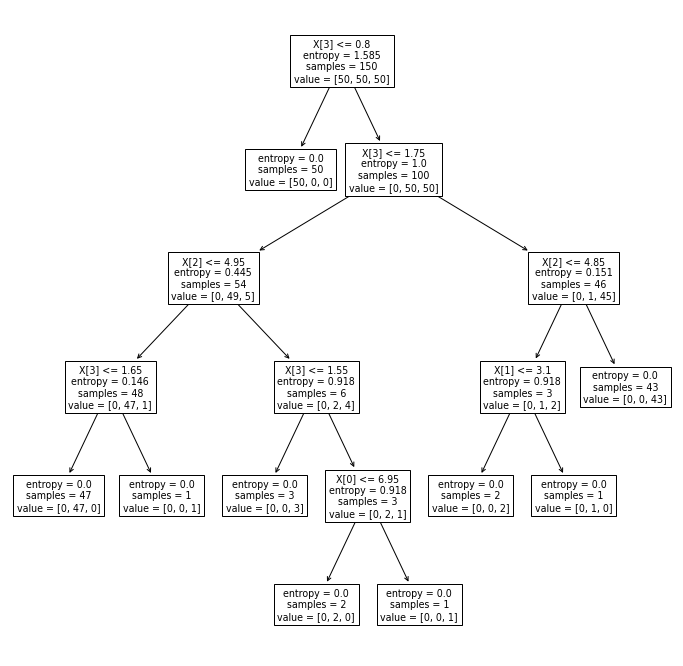

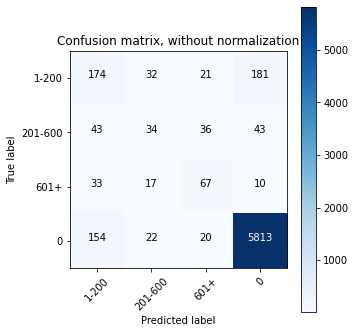

In [185]:
# Decision Tree Classifier (has to be able to deal with floats)
# choose entropy as it provides better accuracy than Gini impurity and 
# choose max depth so there is a stopping position and the tree does not overfit the data

# initialize classifier
DT = tree.DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=8)

# under-sampling data to remove samples from over-represented '0' class
re_sample = TomekLinks(random_state=0,sampling_strategy="majority")
X_train_res, y_train_res = re_sample.fit_sample(X_train,y_train)

# fit the classifier using the training data
DT = DT.fit(X_train_res, y_train_res)

# Predict the test class labels using the trained DT classifier 
y_pred = DT.predict(X_test)

# plot the tree
fig = plt.figure(figsize = (12,12))
iris = load_iris()
tree.plot_tree(DT.fit(iris.data, iris.target)) 

# print accuracy of the classifier
print(classification_report(y_test, y_pred))

# print confusion matrix to show distribution of imbalanced classes
fig2 = plt.figure(figsize = (5,5))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, ['1-200','201-600','601+','0'],
                      title='Confusion matrix, without normalization')

# tree_depth = []
# f1s_micro = []
# f1s_macro = []
# f1s_weighted = []

# for depth in range(1,100):

#   # initialize classifier
#   DT = tree.DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=depth)

#   # under-sampling data to remove samples from over-represented '0' class
#   re_sample = TomekLinks(random_state=0, sampling_strategy = "majority")
#   X_train_res, y_train_res = re_sample.fit_sample(X_train,y_train)

#   # fit the classifier using the training data
#   DT = DT.fit(X_train_res, y_train_res)

#   # Predict the test class labels using the trained DT classifier 
#   y_pred = DT.predict(X_test)

#   tree_depth.append(depth)
#   f1s_macro.append(f1_score(y_test, y_pred,average='macro'))
#   f1s_micro.append(f1_score(y_test, y_pred,average='micro'))
#   f1s_weighted.append(f1_score(y_test, y_pred,average='weighted'))

# fig, axes = plt.subplots(1, 1)

# axes.plot(tree_depth,f1s_micro)
# axes.plot(tree_depth,f1s_macro)
# axes.plot(tree_depth,f1s_weighted)
# labels = ["Micro average","Macro average","Weighted average"]
# axes.legend(axes.get_lines(), labels, loc=8)
# plt.ylabel('Accuracy')
# plt.xlabel('Depth of Tree')
# plt.title('Effect of Tree Depth on Accuracy Using Gini Impurity')
# plt.show()
